In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/speech-commands-v2/LICENSE
/kaggle/input/speech-commands-v2/testing_list.txt
/kaggle/input/speech-commands-v2/README.md
/kaggle/input/speech-commands-v2/validation_list.txt
/kaggle/input/speech-commands-v2/no/4c6944d6_nohash_3.wav
/kaggle/input/speech-commands-v2/no/4e99c1b7_nohash_3.wav
/kaggle/input/speech-commands-v2/no/97f4c236_nohash_3.wav
/kaggle/input/speech-commands-v2/no/cb2929ce_nohash_3.wav
/kaggle/input/speech-commands-v2/no/ca4d5368_nohash_3.wav
/kaggle/input/speech-commands-v2/no/ad63d93c_nohash_1.wav
/kaggle/input/speech-commands-v2/no/aeb99b1c_nohash_1.wav
/kaggle/input/speech-commands-v2/no/89947bd7_nohash_4.wav
/kaggle/input/speech-commands-v2/no/c5a1e46c_nohash_3.wav
/kaggle/input/speech-commands-v2/no/0a2b400e_nohash_0.wav
/kaggle/input/speech-commands-v2/no/45692b02_nohash_1.wav
/kaggle/input/speech-commands-v2/no/9d32f10a_nohash_0.wav
/kaggle/input/speech-commands-v2/no/14c2b13d_nohash_0.wav
/kaggle/input/speech-commands-v2/no/01648c51_nohash_1.wav
/

# IMPORTS & CONFIGURATION

In [2]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
import librosa
from pathlib import Path
from tqdm.notebook import tqdm
import json
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
import warnings
warnings.filterwarnings('ignore')

print("TensorFlow version:", tf.__version__)
print("GPU Available:", len(tf.config.list_physical_devices('GPU')) > 0)

# Configuration
class Config:
    """Centralized configuration"""
    
    # Dataset paths (auto-detect)
    
    DATASET_PATH = "/kaggle/input/speech-commands-v2"
    
    # Keywords - CUSTOMIZE THESE
    KEYWORDS = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off']
    CLASSES = KEYWORDS + ['_silence_', '_unknown_']
    NUM_CLASSES = len(CLASSES)
    
    # Audio parameters
    SAMPLE_RATE = 16000
    DURATION = 1.0
    SAMPLES_PER_AUDIO = int(SAMPLE_RATE * DURATION)
    
    # Feature extraction
    N_MFCC = 13
    N_FFT = 256
    HOP_LENGTH = 160
    FRAME_LENGTH = 400
    
    # Training parameters
    BATCH_SIZE = 64
    EPOCHS = 50
    LEARNING_RATE = 0.001
    
    # Data augmentation
    TIME_SHIFT_MS = 100
    BACKGROUND_FREQUENCY = 0.8
    BACKGROUND_VOLUME_RANGE = (0.05, 0.15)
    VOLUME_SCALE_RANGE = (0.7, 1.3)
    
    # CRITICAL: Balance the dataset
    BALANCE_UNKNOWN_CLASS = True  
    MAX_UNKNOWN_MULTIPLIER = 3  # Unknown can be at most 3x a keyword class
    
    # Paths
    OUTPUT_DIR = "/kaggle/working"
    DATA_CACHE_DIR = "/kaggle/working/data_cache"
    
    # Options
    USE_CLASS_WEIGHTS = True
    QUANTIZE_MODEL = True
    
    RANDOM_SEED = 42

config = Config()


# Create directories
os.makedirs(config.OUTPUT_DIR, exist_ok=True)
os.makedirs(config.DATA_CACHE_DIR, exist_ok=True)

# Set seeds
random.seed(config.RANDOM_SEED)
np.random.seed(config.RANDOM_SEED)
tf.random.set_seed(config.RANDOM_SEED)

print("\n" + "="*60)
print("CONFIGURATION")
print("="*60)
print(f"Dataset: {config.DATASET_PATH}")
print(f"Keywords: {config.KEYWORDS}")
print(f"Classes: {config.CLASSES}")
print(f"Output: {config.OUTPUT_DIR}")
print("="*60)

TensorFlow version: 2.18.0
GPU Available: True

CONFIGURATION
Dataset: /kaggle/input/speech-commands-v2
Keywords: ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off']
Classes: ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', '_silence_', '_unknown_']
Output: /kaggle/working


# DATA LOADER CLASS

In [3]:
class SpeechDataLoader:
    """Handles all data loading and preprocessing"""
    
    def __init__(self, config):
        self.config = config
        self.dataset_path = Path(config.DATASET_PATH)
        self.background_noise_data = []
        
        # Load split files
        self.validation_list = self._load_split_file('validation_list.txt')
        self.testing_list = self._load_split_file('testing_list.txt')
        
        # Load background noise
        self._load_background_noise()
        
        print(f"✓ DataLoader initialized")
        print(f"  Validation files: {len(self.validation_list)}")
        print(f"  Test files: {len(self.testing_list)}")
        print(f"  Background noise files: {len(self.background_noise_data)}")
    
    def _load_split_file(self, filename):
        """Load validation/test split file"""
        split_file = self.dataset_path / filename
        if split_file.exists():
            with open(split_file, 'r') as f:
                return set(line.strip() for line in f)
        return set()
    
    def _load_background_noise(self):
        """Load background noise files"""
        bg_dir = self.dataset_path / '_background_noise_'
        if bg_dir.exists():
            for noise_file in bg_dir.glob('*.wav'):
                try:
                    audio, _ = librosa.load(noise_file, sr=self.config.SAMPLE_RATE)
                    self.background_noise_data.append(audio)
                except Exception as e:
                    pass
    
    def get_file_paths_and_labels(self):
        """Scan dataset and return train/val/test splits"""
        train_files, val_files, test_files = [], [], []
        
        word_dirs = [d for d in self.dataset_path.iterdir() 
                     if d.is_dir() and not d.name.startswith('_')]
        
        for word_dir in tqdm(word_dirs, desc="Scanning dataset"):
            # Determine label
            if word_dir.name in self.config.KEYWORDS:
                label = self.config.KEYWORDS.index(word_dir.name)
                label_name = word_dir.name
            else:
                label = self.config.NUM_CLASSES - 1  # _unknown_
                label_name = "_unknown_"
            
            for wav_file in word_dir.glob('*.wav'):
                rel_path = f"{word_dir.name}/{wav_file.name}"
                file_info = (str(wav_file), label, label_name)
                
                if rel_path in self.validation_list:
                    val_files.append(file_info)
                elif rel_path in self.testing_list:
                    test_files.append(file_info)
                else:
                    train_files.append(file_info)
        
        return train_files, val_files, test_files
    
    def load_audio(self, file_path, augment=False):
        """Load and preprocess audio"""
        audio, _ = librosa.load(file_path, sr=self.config.SAMPLE_RATE)
        
        # Ensure 1 second
        if len(audio) < self.config.SAMPLES_PER_AUDIO:
            audio = np.pad(audio, (0, self.config.SAMPLES_PER_AUDIO - len(audio)))
        else:
            audio = audio[:self.config.SAMPLES_PER_AUDIO]
        
        if augment:
            audio = self._augment_audio(audio)
        
        return audio
    
    def _augment_audio(self, audio):
        """Apply data augmentation"""
        # Time shift
        shift_samples = int(self.config.TIME_SHIFT_MS * self.config.SAMPLE_RATE / 1000)
        shift = np.random.randint(-shift_samples, shift_samples)
        audio = np.roll(audio, shift)
        if shift > 0:
            audio[:shift] = 0
        else:
            audio[shift:] = 0
        
        # Background noise
        if self.background_noise_data and np.random.random() < self.config.BACKGROUND_FREQUENCY:
            bg_noise = random.choice(self.background_noise_data)
            if len(bg_noise) > self.config.SAMPLES_PER_AUDIO:
                start = np.random.randint(0, len(bg_noise) - self.config.SAMPLES_PER_AUDIO)
                bg_noise = bg_noise[start:start + self.config.SAMPLES_PER_AUDIO]
            else:
                bg_noise = np.pad(bg_noise, (0, self.config.SAMPLES_PER_AUDIO - len(bg_noise)))
            
            volume = np.random.uniform(*self.config.BACKGROUND_VOLUME_RANGE)
            audio = audio + volume * bg_noise
        
        # Volume scaling
        volume_scale = np.random.uniform(*self.config.VOLUME_SCALE_RANGE)
        audio = audio * volume_scale
        
        return np.clip(audio, -1.0, 1.0)
    
    def generate_silence_samples(self, num_samples):
        """Generate silence samples"""
        silence_samples = []
        for _ in range(num_samples):
            if self.background_noise_data and np.random.random() < 0.7:
                bg_noise = random.choice(self.background_noise_data)
                if len(bg_noise) > self.config.SAMPLES_PER_AUDIO:
                    start = np.random.randint(0, len(bg_noise) - self.config.SAMPLES_PER_AUDIO)
                    audio = bg_noise[start:start + self.config.SAMPLES_PER_AUDIO]
                else:
                    audio = np.pad(bg_noise, (0, self.config.SAMPLES_PER_AUDIO - len(bg_noise)))
                audio = audio * np.random.uniform(0.05, 0.3)
            else:
                audio = np.random.normal(0, 0.001, self.config.SAMPLES_PER_AUDIO)
            silence_samples.append(audio)
        return silence_samples
    
    def extract_features(self, audio):
        """Extract MFCC features"""
        mfcc = librosa.feature.mfcc(
            y=audio,
            sr=self.config.SAMPLE_RATE,
            n_mfcc=self.config.N_MFCC,
            n_fft=self.config.N_FFT,
            hop_length=self.config.HOP_LENGTH
        )
        mfcc = (mfcc - np.mean(mfcc, axis=1, keepdims=True)) / (np.std(mfcc, axis=1, keepdims=True) + 1e-8)
        return mfcc.T

print("✓ SpeechDataLoader class defined")

✓ SpeechDataLoader class defined


# MODEL ARCHITECTURES

In [4]:
def build_baseline_model(input_shape, num_classes):
    """
    BASELINE: Your current Hybrid Micro CNN
    
    Specs:
    - Parameters: ~150K
    - Size: ~40KB (INT8)
    - Inference: ~50-60ms
    - Expected Accuracy: 92-94%
    
    This is your current architecture
    """
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        
        # Block 1: Standard Conv
        layers.Conv1D(32, 3, strides=1, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2),
        
        # Block 2: Depthwise Separable
        layers.SeparableConv1D(64, 3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2),
        layers.Dropout(0.25),
        
        # Block 3: Another DS Conv
        layers.SeparableConv1D(128, 3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling1D(),
        
        # Dense Head
        layers.Dense(128, activation='relu',
                     kernel_regularizer=regularizers.l2(1e-4)),
        layers.Dropout(0.35),
        layers.Dense(num_classes, activation='softmax')
    ], name='Baseline_Hybrid_Micro_CNN')
    
    return model


def build_medium_simplified(input_shape, num_classes):
    """
    MEDIUM SIMPLIFICATION
    
    Changes:
    - Filters: 32→16, 64→32, 128→64
    - Dense: 128→64
    - Stride 2 in first conv (faster reduction)
    
    Specs:
    - Parameters: ~40K (73% reduction)
    - Size: ~4KB (INT8) (90% reduction)
    - Inference: ~30-35ms (40% faster)
    - Expected Accuracy: 89-92% (2-3% drop)
    
    RECOMMENDED: Best balance of size and accuracy
    """
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        
        # Block 1: Standard Conv with stride 2
        layers.Conv1D(16, 3, strides=2, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2),
        
        # Block 2: Depthwise Separable
        layers.SeparableConv1D(32, 3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2),
        layers.Dropout(0.25),
        
        # Block 3: Depthwise Separable
        layers.SeparableConv1D(64, 3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling1D(),
        
        # Dense Head
        layers.Dense(64, activation='relu',
                     kernel_regularizer=regularizers.l2(1e-4)),
        layers.Dropout(0.35),
        layers.Dense(num_classes, activation='softmax')
    ], name='Medium_Simplified_CNN')
    
    return model


def build_very_high_simplified(input_shape, num_classes):
    """
    VERY HIGH SIMPLIFICATION
    
    Changes:
    - Filters: 8→16→32 (minimum)
    - Remove one conv block
    - Remove dense layer (direct to output)
    - Aggressive strides
    
    Specs:
    - Parameters: ~10K (93% reduction)
    - Size: ~2KB (INT8) (95% reduction)
    - Inference: ~15-20ms (70% faster)
    - Expected Accuracy: 85-88% (5-7% drop)
    
    Use when: Maximum compression needed
    """
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        
        # Block 1: Aggressive Conv
        layers.Conv1D(8, 3, strides=2, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2),
        
        # Block 2: Depthwise Separable
        layers.SeparableConv1D(16, 3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2),
        layers.Dropout(0.25),
        
        # Block 3: Depthwise Separable (smaller)
        layers.SeparableConv1D(32, 3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling1D(),
        
        # Direct to output (no dense layer)
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ], name='VeryHigh_Simplified_CNN')
    
    return model


def build_ultra_simplified(input_shape, num_classes):
    """
    ULTRA SIMPLIFICATION (EXTREME)
    
    Changes:
    - Minimal filters: 8→16
    - Only 2 blocks
    - No pooling, only strides
    - Minimal structure
    
    Specs:
    - Parameters: ~5K (97% reduction)
    - Size: ~1KB (INT8) (97% reduction)
    - Inference: ~10-15ms (75% faster)
    - Expected Accuracy: 82-85% (8-10% drop)
    
    Use when: Proof of concept, ultra-constrained devices
    """
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        
        # Block 1: Aggressive stride
        layers.Conv1D(8, 8, strides=4, padding='same', activation='relu'),
        layers.BatchNormalization(),
        
        # Block 2: Final conv
        layers.SeparableConv1D(16, 3, strides=2, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling1D(),
        
        # Output
        layers.Dense(num_classes, activation='softmax')
    ], name='Ultra_Simplified_CNN')
    
    return model

# PREPARE DATASETS 

In [5]:
def prepare_datasets(config, force_reload=False):
    """
    Prepare and cache datasets
    Run this cell once, then use cached data for training
    """
    
    cache_file = os.path.join(config.DATA_CACHE_DIR, 'processed_data.pkl')
    
    # Check if cached data exists
    if os.path.exists(cache_file) and not force_reload:
        print("="*60)
        print("LOADING CACHED DATASETS")
        print("="*60)
        print(f"Loading from: {cache_file}")
        
        with open(cache_file, 'rb') as f:
            data = pickle.load(f)
        
        print("✓ Datasets loaded from cache")
        print(f"  Train: {data['X_train'].shape}")
        print(f"  Val: {data['X_val'].shape}")
        print(f"  Test: {data['X_test'].shape}")
        
        return data
    
    # Process from scratch
    print("="*60)
    print("PREPARING DATASETS FROM SCRATCH")
    print("="*60)
    
    # Initialize data loader
    data_loader = SpeechDataLoader(config)
    
    # Get file lists
    print("\nScanning dataset...")
    train_files, val_files, test_files = data_loader.get_file_paths_and_labels()
    
    print(f"  Train files: {len(train_files)}")
    print(f"  Validation files: {len(val_files)}")
    print(f"  Test files: {len(test_files)}")
    
    # CRITICAL: Balance unknown class
    if config.BALANCE_UNKNOWN_CLASS:
        print("\n⚠ Balancing unknown class to prevent dominance...")
        
        unknown_label = config.NUM_CLASSES - 1
        
        def balance_unknown(file_list, split_name):
            # Separate unknown from others
            unknown_files = [f for f in file_list if f[1] == unknown_label]
            other_files = [f for f in file_list if f[1] != unknown_label]
            
            # Calculate max allowed unknown samples
            avg_per_class = len(other_files) / (config.NUM_CLASSES - 1)
            max_unknown = int(avg_per_class * config.MAX_UNKNOWN_MULTIPLIER)
            
            print(f"  {split_name}:")
            print(f"    Original unknown: {len(unknown_files)}")
            print(f"    Other classes avg: {int(avg_per_class)}")
            print(f"    Max unknown allowed: {max_unknown}")
            
            # Subsample unknown if needed
            if len(unknown_files) > max_unknown:
                unknown_files = random.sample(unknown_files, max_unknown)
                print(f"    ✓ Reduced unknown to: {len(unknown_files)}")
            
            return other_files + unknown_files
        
        train_files = balance_unknown(train_files, "Train")
        val_files = balance_unknown(val_files, "Validation")
        test_files = balance_unknown(test_files, "Test")
    
    # Process each split
    silence_label = config.NUM_CLASSES - 2
    
    def process_split(file_list, split_name, augment=False, add_silence=True):
        print(f"\nProcessing {split_name} set...")
        features_list = []
        labels_list = []
        
        # Shuffle for better training
        random.shuffle(file_list)
        
        # Process audio files
        for file_path, label, _ in tqdm(file_list, desc=f"{split_name}"):
            audio = data_loader.load_audio(file_path, augment=augment)
            features = data_loader.extract_features(audio)
            features_list.append(features)
            labels_list.append(label)
        
        # Add silence samples
        if add_silence:
            if augment:
                num_silence = len(file_list) // 10
            else:
                num_silence = max(50, len(file_list) // 20)
            
            print(f"  Generating {num_silence} silence samples...")
            silence_samples = data_loader.generate_silence_samples(num_silence)
            
            for audio in tqdm(silence_samples, desc=f"{split_name} silence"):
                features = data_loader.extract_features(audio)
                features_list.append(features)
                labels_list.append(silence_label)
        
        X = np.array(features_list)
        y = np.array(labels_list)
        
        print(f"  ✓ {split_name} shape: {X.shape}")
        return X, y
    
    # Process all splits
    X_train, y_train = process_split(train_files, "Train", augment=True)
    X_val, y_val = process_split(val_files, "Validation", augment=True)
    X_test, y_test = process_split(test_files, "Test", augment=True)
    
    # Analyze class distribution
    print("\n" + "="*60)
    print("CLASS DISTRIBUTION")
    print("="*60)
    
    for split_name, y_data in [("Train", y_train), ("Val", y_val), ("Test", y_test)]:
        unique, counts = np.unique(y_data, return_counts=True)
        print(f"\n{split_name}:")
        total = len(y_data)
        for cls_idx, count in zip(unique, counts):
            if cls_idx < len(config.CLASSES):
                pct = count / total * 100
                print(f"  {config.CLASSES[cls_idx]:15s}: {count:5d} ({pct:5.1f}%)")
    
    # Save to cache
    data = {
        'X_train': X_train,
        'y_train': y_train,
        'X_val': X_val,
        'y_val': y_val,
        'X_test': X_test,
        'y_test': y_test,
        'config': {
            'keywords': config.KEYWORDS,
            'classes': config.CLASSES,
            'n_mfcc': config.N_MFCC,
            'sample_rate': config.SAMPLE_RATE
        }
    }
    
    print(f"\nSaving to cache: {cache_file}")
    with open(cache_file, 'wb') as f:
        pickle.dump(data, f)
    
    print("\n✓ Dataset preparation complete!")
    
    return data

# RUN THIS TO PREPARE DATA
print("\n" + "="*60)
print("READY TO PREPARE DATASETS")
print("="*60)
print("Run: data = prepare_datasets(config)")
print("Or force reload: data = prepare_datasets(config, force_reload=True)")


READY TO PREPARE DATASETS
Run: data = prepare_datasets(config)
Or force reload: data = prepare_datasets(config, force_reload=True)


# TRAIN MODEL

In [6]:
def train_model(data, config):
    """Train the keyword spotting model"""
    
    print("="*60)
    print("TRAINING MODEL")
    print("="*60)
    
    # Unpack data
    X_train = data['X_train']
    y_train = data['y_train']
    X_val = data['X_val']
    y_val = data['y_val']
    
    # Build model
    input_shape = X_train.shape[1:]
    model = build_model(input_shape, config.NUM_CLASSES)
    
    print("\nModel Architecture:")
    model.summary()
    
    trainable_params = np.sum([np.prod(v.shape) for v in model.trainable_weights])
    print(f"\nTrainable parameters: {trainable_params:,}")
    
    # Compute class weights
    class_weight_dict = None
    if config.USE_CLASS_WEIGHTS:
        print("\nComputing class weights...")
        class_weights = compute_class_weight(
            'balanced',
            classes=np.unique(y_train),
            y=y_train
        )
        class_weight_dict = dict(enumerate(class_weights))
        
        print("Class weights:")
        for cls_idx, weight in class_weight_dict.items():
            if cls_idx < len(config.CLASSES):
                print(f"  {config.CLASSES[cls_idx]:15s}: {weight:.2f}")
    
    # Compile
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=config.LEARNING_RATE),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Callbacks
    callbacks = [
        keras.callbacks.ModelCheckpoint(
            os.path.join(config.OUTPUT_DIR, 'best_model.keras'),
            monitor='val_accuracy',
            save_best_only=True,
            mode='max',
            verbose=1
        ),
        keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=7,
            restore_best_weights=True,
            mode='max',
            verbose=1
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-6,
            verbose=1
        )
    ]
    
    # Train
    print("\n" + "="*60)
    print("TRAINING STARTED")
    print("="*60)
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        batch_size=config.BATCH_SIZE,
        epochs=config.EPOCHS,
        callbacks=callbacks,
        class_weight=class_weight_dict,
        verbose=1
    )
    
    # Plot training history
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    axes[0].plot(history.history['accuracy'], label='Train')
    axes[0].plot(history.history['val_accuracy'], label='Validation')
    axes[0].set_title('Model Accuracy', fontweight='bold')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    axes[1].plot(history.history['loss'], label='Train')
    axes[1].plot(history.history['val_loss'], label='Validation')
    axes[1].set_title('Model Loss', fontweight='bold')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(config.OUTPUT_DIR, 'training_history.png'), dpi=150)
    plt.show()
    
    print("\n✓ Training complete!")
    return model, history

print("✓ Training function defined")
print("Run: model, history = train_model(data, config)")

✓ Training function defined
Run: model, history = train_model(data, config)


# EVALUATE MODEL

In [7]:
def evaluate_model(model, data, config, name):
    """Comprehensive model evaluation"""
    
    print("="*60)
    print("MODEL EVALUATION")
    print("="*60)
    
    X_test = data['X_test']
    y_test = data['y_test']
    
    # Predictions
    print("\nGenerating predictions...")
    y_pred_proba = model.predict(X_test, verbose=0)
    y_pred = np.argmax(y_pred_proba, axis=1)
    
    # Accuracy and loss
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"\n✓ Test Accuracy: {test_acc:.4f}")
    print(f"✓ Test Loss: {test_loss:.4f}")
    
    # Classification report
    print("\nClassification Report:")
    print("="*60)
    print(classification_report(y_test, y_pred, target_names=config.CLASSES, zero_division=0))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=config.CLASSES, yticklabels=config.CLASSES)
    plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(os.path.join(config.OUTPUT_DIR, name+' confusion_matrix.png'), dpi=150)
    plt.show()
    
    # Save results
    results = {
        'test_accuracy': float(test_acc),
        'test_loss': float(test_loss),
        'classification_report': classification_report(y_test, y_pred, 
                                                       target_names=config.CLASSES, 
                                                       output_dict=True, zero_division=0)
    }
    
    with open(os.path.join(config.OUTPUT_DIR, name+' evaluation_results.json'), 'w') as f:
        json.dump(results, f, indent=2)
    
    print("\n✓ Evaluation complete!")
    return results

print("✓ Evaluation function defined")
print("Run: results = evaluate_model(model, data, config)")

✓ Evaluation function defined
Run: results = evaluate_model(model, data, config)


# CONVERT TO TFLITE

In [8]:
def convert_to_tflite(model, data, config, name):
    """Convert model to TensorFlow Lite"""
    
    print("="*60)
    print("TENSORFLOW LITE CONVERSION")
    print("="*60)
    
    # Representative dataset
    X_sample = data['X_train'][:500]
    
    def representative_dataset():
        for i in range(len(X_sample)):
            yield [X_sample[i:i+1].astype(np.float32)]
    
    # Convert
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    
    if config.QUANTIZE_MODEL:
        print("\nApplying INT8 quantization...")
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
        converter.representative_dataset = representative_dataset
        converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
        converter.inference_input_type = tf.int8
        converter.inference_output_type = tf.int8
    
    tflite_model = converter.convert()
    
    # Save
    tflite_path = os.path.join(config.OUTPUT_DIR, name)
    with open(tflite_path, 'wb') as f:
        f.write(tflite_model)
    
    print(f"\n✓ TFLite model saved: {tflite_path}")
    print(f"✓ Model size: {len(tflite_model) / 1024:.2f} KB")
    
    return tflite_path

print("✓ TFLite conversion function defined")
print("Run: tflite_path = convert_to_tflite(model, data, config)")




✓ TFLite conversion function defined
Run: tflite_path = convert_to_tflite(model, data, config)


In [ ]:
data = prepare_datasets(config)

PREPARING DATASETS FROM SCRATCH
✓ DataLoader initialized
  Validation files: 9981
  Test files: 11005
  Background noise files: 6

Scanning dataset...


Scanning dataset:   0%|          | 0/35 [00:00<?, ?it/s]

  Train files: 84843
  Validation files: 9981
  Test files: 11005

⚠ Balancing unknown class to prevent dominance...
  Train:
    Original unknown: 60291
    Other classes avg: 2728
    Max unknown allowed: 8184
    ✓ Reduced unknown to: 8184
  Validation:
    Original unknown: 7000
    Other classes avg: 331
    Max unknown allowed: 993
    ✓ Reduced unknown to: 993
  Test:
    Original unknown: 7744
    Other classes avg: 362
    Max unknown allowed: 1087
    ✓ Reduced unknown to: 1087

Processing Train set...


Train:   0%|          | 0/32736 [00:00<?, ?it/s]

  Generating 3273 silence samples...


Train silence:   0%|          | 0/3273 [00:00<?, ?it/s]

  ✓ Train shape: (36009, 101, 13)

Processing Validation set...


Validation:   0%|          | 0/3974 [00:00<?, ?it/s]

# =======================

# Training models and results

558/563 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8228 - loss: 0.4584
Epoch 4: val_accuracy improved from 0.85198 to 0.86090, saving model to /kaggle/working/best_model.keras
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8228 - loss: 0.4583 - val_accuracy: 0.8609 - val_loss: 0.4176 - learning_rate: 0.0010
Epoch 5/50
554/563 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8362 - loss: 0.4258
Epoch 5: val_accuracy improved from 0.86090 to 0.87188, saving model to /kaggle/working/best_model.keras
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8362 - loss: 0.4257 - val_accuracy: 0.8719 - val_loss: 0.3953 - learning_rate: 0.0010
Epoch 6/50
561/563 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8459 - loss: 0.4079
Epoch 6: val_accuracy did not improve from 0.87188
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8459 - loss: 0.4078 - val_accuracy: 0.8719 - val_loss: 0.3933 - learning_rate: 0.0010
Epoch 7/50
556/563 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.847

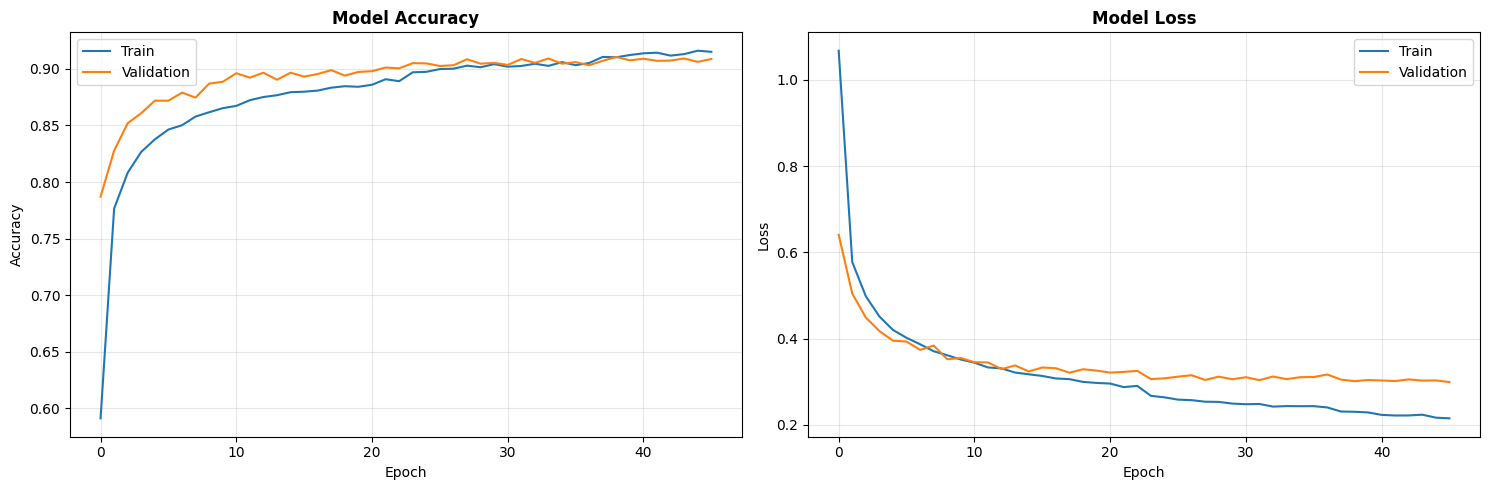


✓ Training complete!
MODEL EVALUATION

Generating predictions...

✓ Test Accuracy: 0.8996
✓ Test Loss: 0.3219

Classification Report:
              precision    recall  f1-score   support

         yes       0.90      0.97      0.93       419
          no       0.86      0.94      0.90       405
          up       0.86      0.92      0.89       425
        down       0.88      0.90      0.89       406
        left       0.90      0.91      0.91       412
       right       0.92      0.93      0.92       396
          on       0.88      0.89      0.89       396
         off       0.88      0.89      0.88       402
   _silence_       0.95      1.00      0.97       434
   _unknown_       0.93      0.80      0.86      1087

    accuracy                           0.90      4782
   macro avg       0.90      0.91      0.90      4782
weighted avg       0.90      0.90      0.90      4782



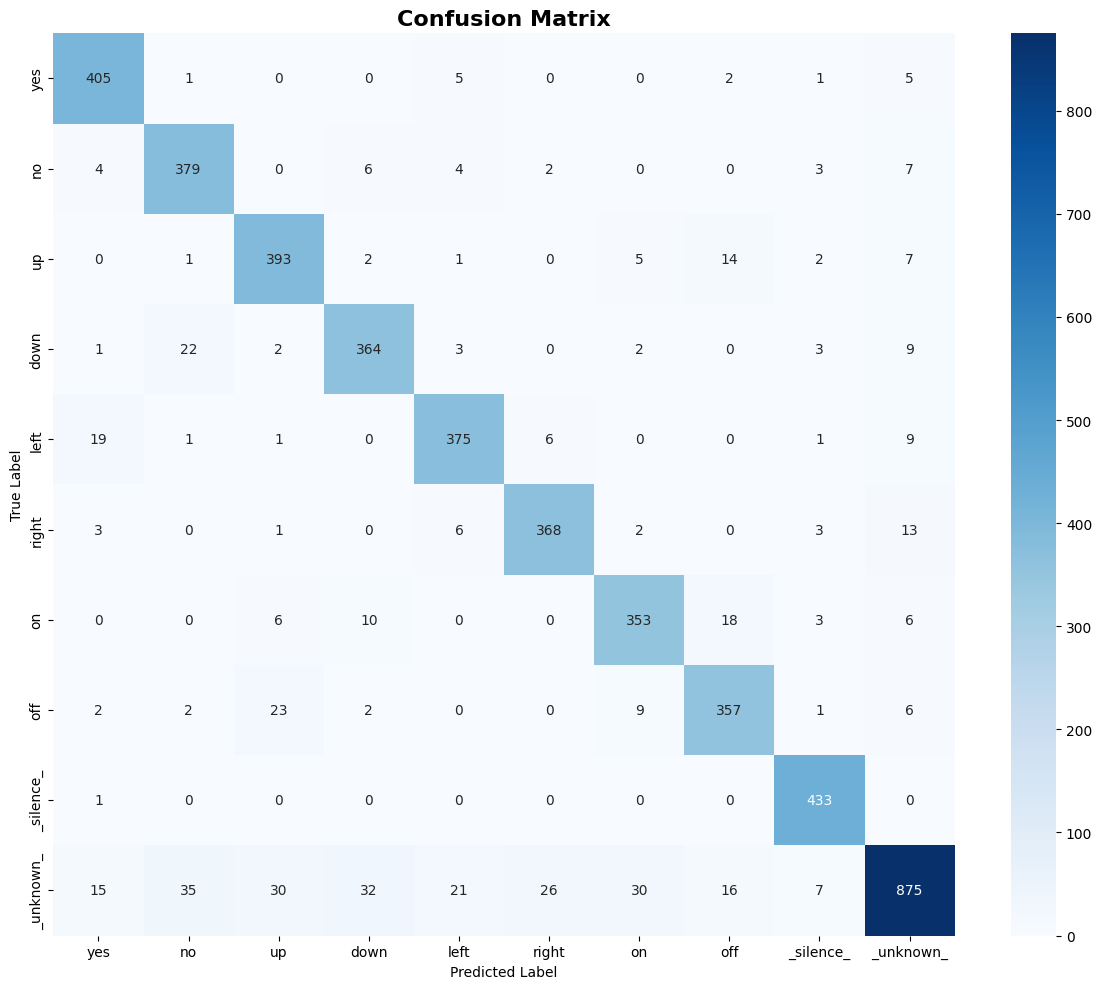


✓ Evaluation complete!
TENSORFLOW LITE CONVERSION

Applying INT8 quantization...
Saved artifact at '/tmp/tmph7p9ab5m'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 101, 13), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  133275566290512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133275566292816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133275566279568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133275566286672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133275578256848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133275578255888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133275566285520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133275566286864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133275566279376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13327

W0000 00:00:1761514629.294714      37 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1761514629.294745      37 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.



✓ TFLite model saved: /kaggle/working/model1.tflite
✓ Model size: 55.77 KB


I0000 00:00:1761514629.307409      37 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled
fully_quantize: 0, inference_type: 6, input_inference_type: INT8, output_inference_type: INT8


In [10]:
def build_model(input_shape, num_classes):
    return build_baseline_model(input_shape, num_classes)
    
model1, history1 = train_model(data, config)
results1 = evaluate_model(model1, data, config, "model1")
tflite_path1 = convert_to_tflite(model1, data, config, "model1.tflite")


TRAINING MODEL

Model Architecture:


Model: "Medium_Simplified_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 51, 16)         │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 51, 16)         │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 25, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv1d_2              │ (None, 25, 32)         │           592 │
│ (SeparableConv1D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 25, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 12, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv1d_3              │ (None, 12, 64)         │         2,208 │
│ (SeparableConv1D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 12, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,698 (33.98 KB)

 Trainable params: 8,474 (33.10 KB)

 Non-trainable params: 224 (896.00 B)


Trainable parameters: 8,474

Computing class weights...
Class weights:
  yes            : 1.12
  no             : 1.15
  up             : 1.22
  down           : 1.15
  left           : 1.19
  right          : 1.19
  on             : 1.17
  off            : 1.21
  _silence_      : 1.10
  _unknown_      : 0.44

TRAINING STARTED
Epoch 1/50
563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3312 - loss: 1.7750
Epoch 1: val_accuracy improved from -inf to 0.68680, saving model to /kaggle/working/best_model.keras
563/563 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.3315 - loss: 1.7743 - val_accuracy: 0.6868 - val_loss: 0.9255 - learning_rate: 0.0010
Epoch 2/50
560/563 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6583 - loss: 0.8928
Epoch 2: val_accuracy improved from 0.68680 to 0.75864, saving model to /kaggle/working/best_model.keras
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6584 - loss: 0.8923 - val_accuracy: 0.7586 - val_loss: 0.6936 - learning_rate: 0.0010
Epoch 3

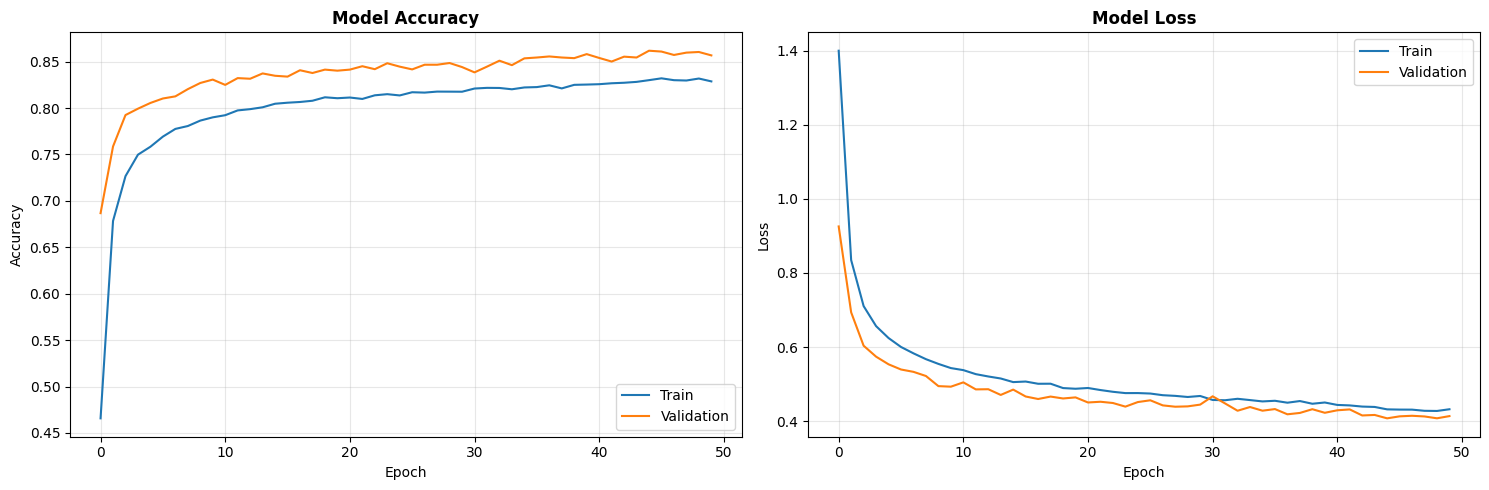


✓ Training complete!
MODEL EVALUATION

Generating predictions...

✓ Test Accuracy: 0.8570
✓ Test Loss: 0.4121

Classification Report:
              precision    recall  f1-score   support

         yes       0.88      0.96      0.92       419
          no       0.78      0.90      0.83       405
          up       0.80      0.91      0.85       425
        down       0.77      0.85      0.81       406
        left       0.86      0.89      0.88       412
       right       0.86      0.92      0.89       396
          on       0.90      0.85      0.88       396
         off       0.88      0.85      0.87       402
   _silence_       0.90      0.99      0.94       434
   _unknown_       0.91      0.69      0.79      1087

    accuracy                           0.86      4782
   macro avg       0.85      0.88      0.87      4782
weighted avg       0.86      0.86      0.85      4782



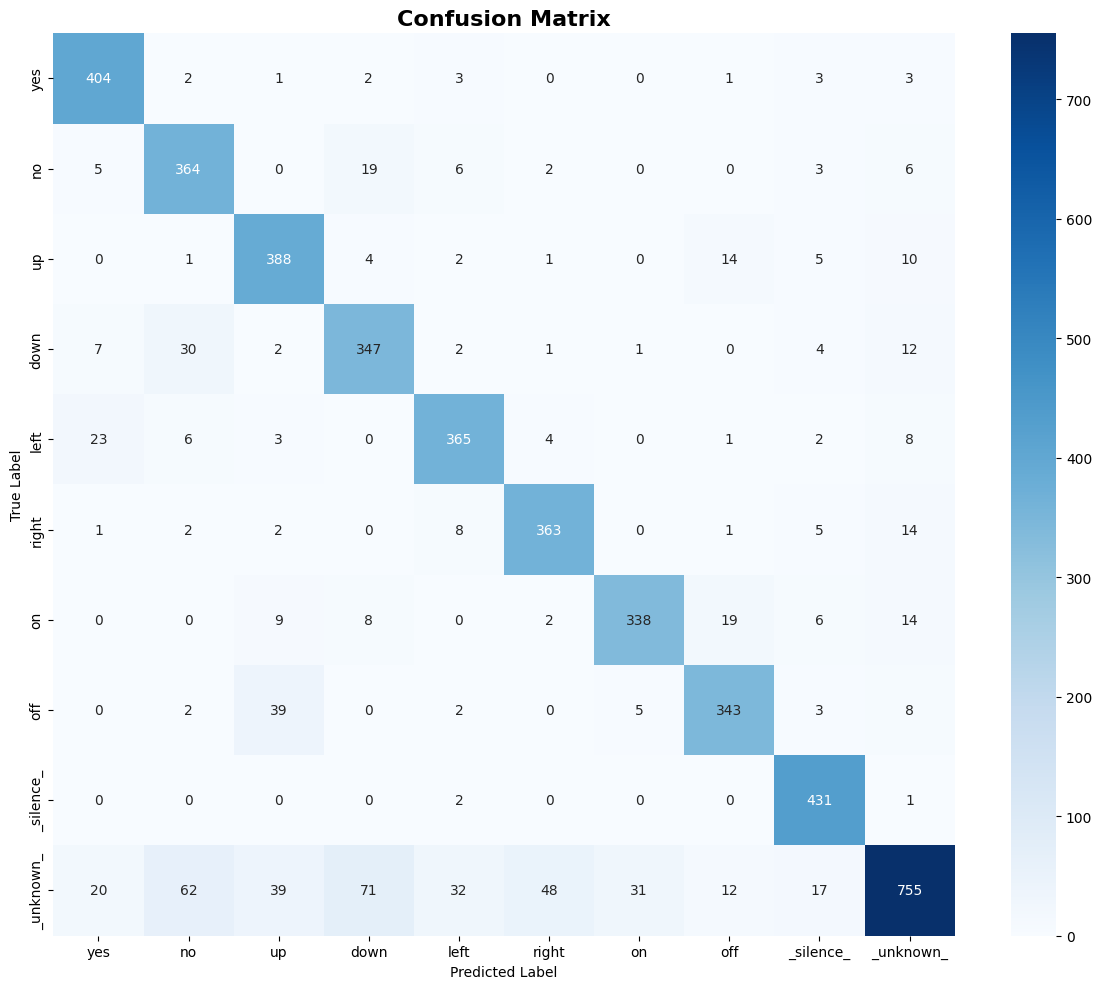


✓ Evaluation complete!
TENSORFLOW LITE CONVERSION

Applying INT8 quantization...
Saved artifact at '/tmp/tmpv3lvveef'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 101, 13), dtype=tf.float32, name='keras_tensor_14')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  133275566282448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133275566290704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133275566281488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133275566282640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133275566285328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133275566280144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133275566281104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133275565748304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133275565748880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13

W0000 00:00:1761514749.022336      37 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1761514749.022368      37 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
fully_quantize: 0, inference_type: 6, input_inference_type: INT8, output_inference_type: INT8


In [11]:
def build_model(input_shape, num_classes):
    return build_medium_simplified(input_shape, num_classes)
    

model2, history2 = train_model(data, config)
results2 = evaluate_model(model2, data, config, "model2")
tflite_path2 = convert_to_tflite(model2, data, config, "model2.tflite")

TRAINING MODEL

Model Architecture:


Model: "VeryHigh_Simplified_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 51, 8)          │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 51, 8)          │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 25, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv1d_4              │ (None, 25, 16)         │           168 │
│ (SeparableConv1D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 25, 16)         │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 12, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 12, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv1d_5              │ (None, 12, 32)         │           592 │
│ (SeparableConv1D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 12, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,634 (6.38 KB)

 Trainable params: 1,522 (5.95 KB)

 Non-trainable params: 112 (448.00 B)


Trainable parameters: 1,522

Computing class weights...
Class weights:
  yes            : 1.12
  no             : 1.15
  up             : 1.22
  down           : 1.15
  left           : 1.19
  right          : 1.19
  on             : 1.17
  off            : 1.21
  _silence_      : 1.10
  _unknown_      : 0.44

TRAINING STARTED
Epoch 1/50
563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1867 - loss: 2.1603
Epoch 1: val_accuracy improved from -inf to 0.43880, saving model to /kaggle/working/best_model.keras
563/563 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.1868 - loss: 2.1599 - val_accuracy: 0.4388 - val_loss: 1.5912 - learning_rate: 0.0010
Epoch 2/50
552/563 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4352 - loss: 1.4959
Epoch 2: val_accuracy improved from 0.43880 to 0.62434, saving model to /kaggle/working/best_model.keras
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4360 - loss: 1.4935 - val_accuracy: 0.6243 - val_loss: 1.1139 - learning_rate: 0.0010
Epoch 3

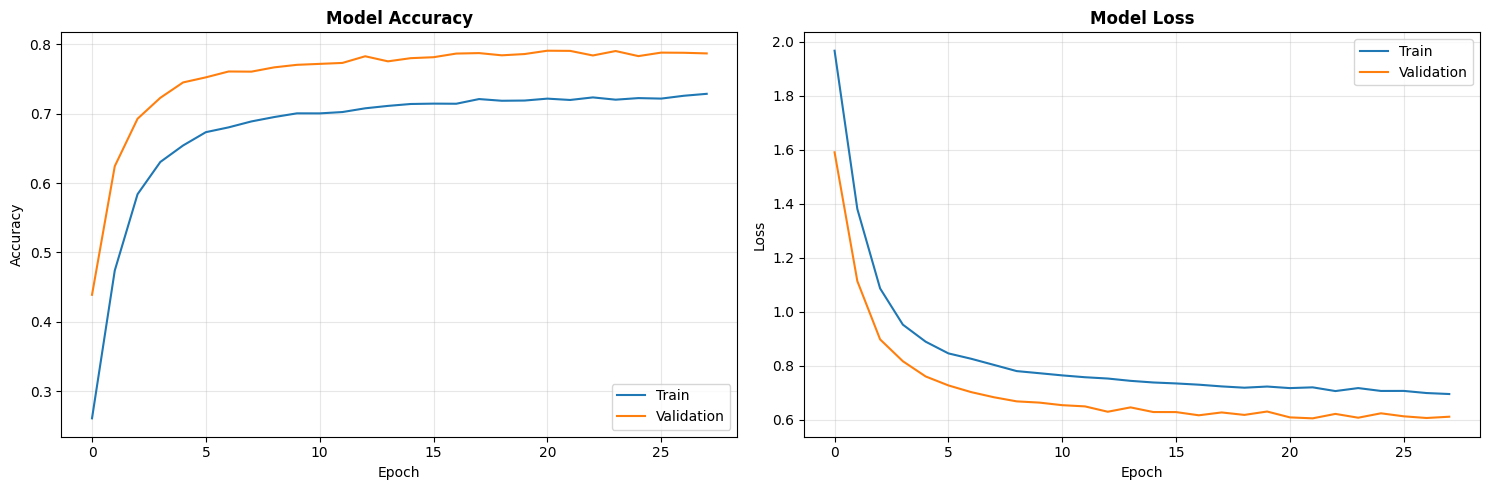


✓ Training complete!
MODEL EVALUATION

Generating predictions...

✓ Test Accuracy: 0.7813
✓ Test Loss: 0.6270

Classification Report:
              precision    recall  f1-score   support

         yes       0.78      0.93      0.85       419
          no       0.67      0.86      0.75       405
          up       0.76      0.86      0.81       425
        down       0.79      0.79      0.79       406
        left       0.75      0.83      0.79       412
       right       0.72      0.85      0.78       396
          on       0.82      0.84      0.83       396
         off       0.84      0.82      0.83       402
   _silence_       0.85      0.99      0.92       434
   _unknown_       0.84      0.50      0.62      1087

    accuracy                           0.78      4782
   macro avg       0.78      0.83      0.80      4782
weighted avg       0.79      0.78      0.77      4782



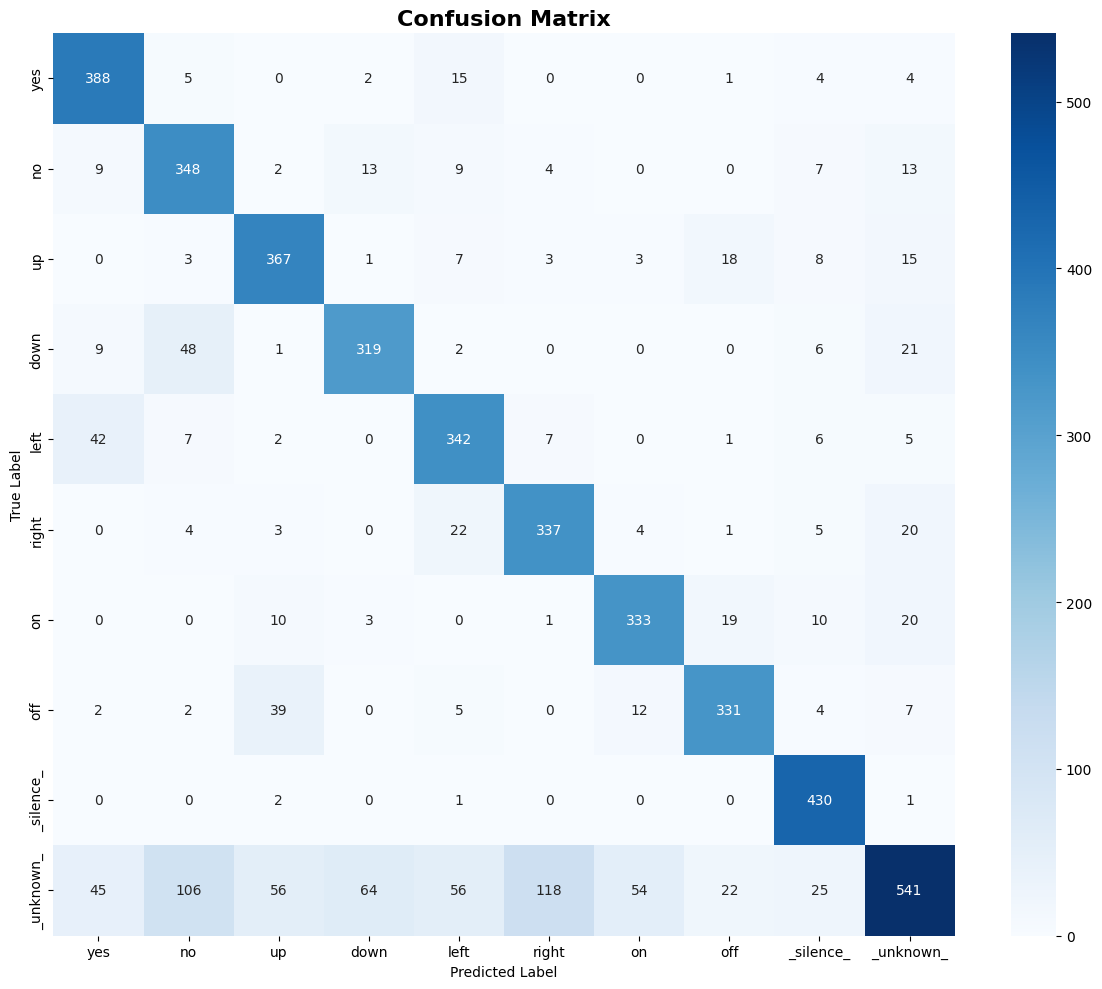


✓ Evaluation complete!
TENSORFLOW LITE CONVERSION

Applying INT8 quantization...
Saved artifact at '/tmp/tmpp1tm9akz'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 101, 13), dtype=tf.float32, name='keras_tensor_28')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  133277401959120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133275565745424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133275578256464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133275578258576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133275578261840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133275578258768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133275578265104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133275578264144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133275578261264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13

W0000 00:00:1761514820.197415      37 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1761514820.197443      37 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
fully_quantize: 0, inference_type: 6, input_inference_type: INT8, output_inference_type: INT8


In [12]:
def build_model(input_shape, num_classes):
    return build_very_high_simplified(input_shape, num_classes)
    

model3, history3 = train_model(data, config)
results3 = evaluate_model(model3, data, config , "model3")
tflite_path3 = convert_to_tflite(model3, data, config, "model3.tflite")

TRAINING MODEL

Model Architecture:


Model: "Ultra_Simplified_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 26, 8)          │           840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 26, 8)          │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv1d_6              │ (None, 13, 16)         │           168 │
│ (SeparableConv1D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 13, 16)         │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_3      │ (None, 16)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,274 (4.98 KB)

 Trainable params: 1,226 (4.79 KB)

 Non-trainable params: 48 (192.00 B)


Trainable parameters: 1,226

Computing class weights...
Class weights:
  yes            : 1.12
  no             : 1.15
  up             : 1.22
  down           : 1.15
  left           : 1.19
  right          : 1.19
  on             : 1.17
  off            : 1.21
  _silence_      : 1.10
  _unknown_      : 0.44

TRAINING STARTED
Epoch 1/50
563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2397 - loss: 2.0534
Epoch 1: val_accuracy improved from -inf to 0.48547, saving model to /kaggle/working/best_model.keras
563/563 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.2399 - loss: 2.0529 - val_accuracy: 0.4855 - val_loss: 1.4660 - learning_rate: 0.0010
Epoch 2/50
558/563 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5082 - loss: 1.2957
Epoch 2: val_accuracy improved from 0.48547 to 0.59643, saving model to /kaggle/working/best_model.keras
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5085 - loss: 1.2948 - val_accuracy: 0.5964 - val_loss: 1.1712 - learning_rate: 0.0010
Epoch 3/5

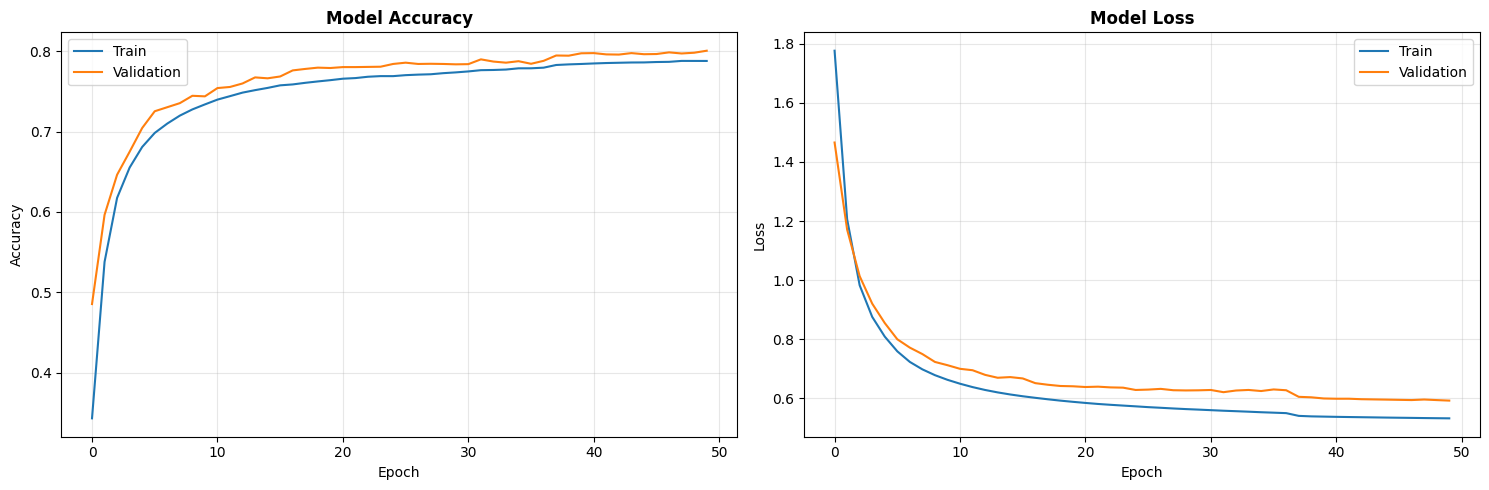


✓ Training complete!
MODEL EVALUATION

Generating predictions...

✓ Test Accuracy: 0.7873
✓ Test Loss: 0.6197

Classification Report:
              precision    recall  f1-score   support

         yes       0.82      0.91      0.87       419
          no       0.64      0.89      0.74       405
          up       0.75      0.84      0.79       425
        down       0.80      0.74      0.77       406
        left       0.76      0.83      0.80       412
       right       0.79      0.86      0.82       396
          on       0.81      0.81      0.81       396
         off       0.79      0.80      0.80       402
   _silence_       0.93      0.98      0.95       434
   _unknown_       0.82      0.57      0.67      1087

    accuracy                           0.79      4782
   macro avg       0.79      0.82      0.80      4782
weighted avg       0.79      0.79      0.78      4782



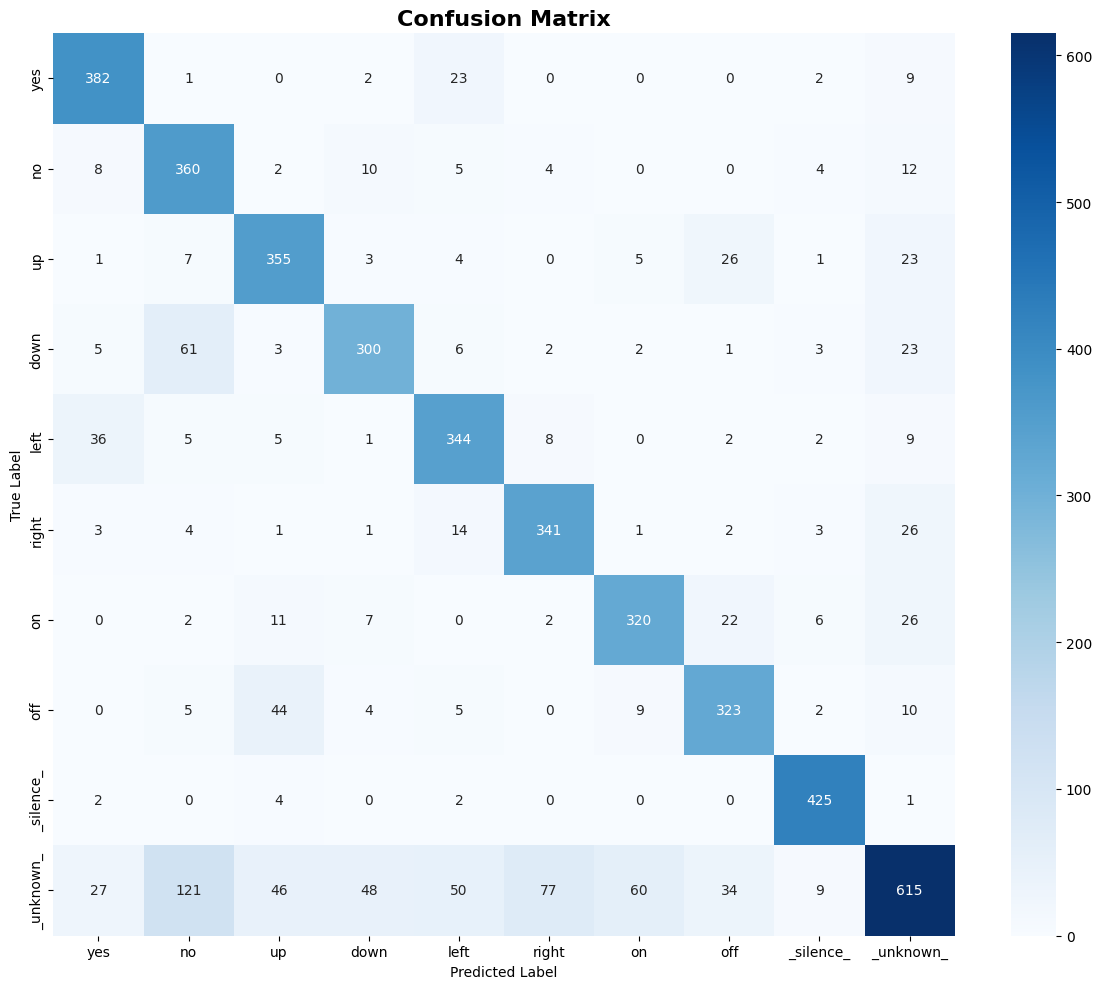


✓ Evaluation complete!
TENSORFLOW LITE CONVERSION

Applying INT8 quantization...
Saved artifact at '/tmp/tmpyz7vk6r4'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 101, 13), dtype=tf.float32, name='keras_tensor_41')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  133277401960464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133275565745040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133275603755728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133275603755920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133277401959696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133275565747344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133275603750352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133275603751312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133275603751504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13

W0000 00:00:1761514917.214845      37 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1761514917.214888      37 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
fully_quantize: 0, inference_type: 6, input_inference_type: INT8, output_inference_type: INT8


In [13]:
def build_model(input_shape, num_classes):
    return build_ultra_simplified(input_shape, num_classes)
    

model4, history4 = train_model(data, config)
results4 = evaluate_model(model4, data, config, "model4")
tflite_path4 = convert_to_tflite(model4, data, config, "model4.tflite")

In [14]:
!zip -r kaggle_working.zip /kaggle/working

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/data_cache/ (stored 0%)
  adding: kaggle/working/data_cache/processed_data.pkl (deflated 45%)
  adding: kaggle/working/model1 evaluation_results.json (deflated 70%)
  adding: kaggle/working/model4 evaluation_results.json (deflated 70%)
  adding: kaggle/working/model3.tflite (deflated 64%)
  adding: kaggle/working/model1.tflite (deflated 35%)
  adding: kaggle/working/model3 evaluation_results.json (deflated 71%)
  adding: kaggle/working/model4 confusion_matrix.png (deflated 16%)
  adding: kaggle/working/.virtual_documents/ (stored 0%)
  adding: kaggle/working/model4.tflite (deflated 60%)
  adding: kaggle/working/model2.tflite (deflated 48%)
  adding: kaggle/working/training_history.png (deflated 11%)
  adding: kaggle/working/best_model.keras (deflated 68%)
  adding: kaggle/working/model1 confusion_matrix.png (deflated 18%)
  adding: kaggle/working/model2 evaluation_results.json (deflated 70%)
  adding: kaggle/working/model3 